<h1 align=center> Analysing Router Downtime </h1>

We try to visualize the text logs our router outputs to figure out why it keeps losing its internet connection.

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
with open("data/hwontdebuglog(4).log", encoding="utf-8") as f:
    entries = f.readlines()

In [27]:
entries

['Manufacturer:Huawei Technologies Co., Ltd;\n',
 'ProductClass:HG8145V5;\n',
 'SerialNumber:48575443B476659D;\n',
 'IP:192.168.100.1;\n',
 'HWVer:15AD.A;\n',
 'SWVer:V5R019C00S125;\n',
 '\n',
 "1981-01-01 00:00:26 [Debug][Debug-Log] static:ETH Port 1 link status changed to Up,Rate is 100 Mbit/s',Work Mode is Full-duplex\n",
 '1981-01-01 00:00:26 [Debug][Debug-Log] static:[L2M]upport state change process. Status=up.\n',
 '1981-01-01 00:00:27 [Debug][Debug-Log] static:[WAN_MNGT] ipv4 if set wan state up pre, wan Index=0x10101001.\n',
 '1981-01-01 00:00:27 [Debug][Debug-Log] static:[WAN_MNGT] ipv4 if set wan state up, wan Index=0x10101001.\n',
 '1981-01-01 00:00:31 [Debug][Debug-Log] static:[ra]send ra notify message! m[0],o[1],lanPrefix[null],mtu[1472],gateway[fe80::1]\n',
 '1981-01-01 00:08:13 [Informational][Debug-Log] static:The service quality of DNS on wan1 is low\n',
 '1981-01-01 00:09:13 [Informational][Debug-Log] static:The service quality of DNS on wan1 is recovered\n',
 '1981-

<h2 align=center> Data Wrangling </h2>

<h3 align=center> Logic </h3>

1. Have each line read in as an element in a list.
2. Loop through the list.  
    1. Find the timestamp where internet connection is lost. This is denoted by `The service quality of DNS on wan1 is low`
    2. Find the timestamp for when internet connection is reestablished. `The service quality of DNS on wan1 is recovered`

In [28]:
help(re.search)

Help on function search in module re:

search(pattern, string, flags=0)
    Scan through string looking for a match to the pattern, returning
    a Match object, or None if no match was found.



In [29]:
def extract_string(regex_t: str) -> str | None:
    """regex_t: the regex to match in the string"""
    search = re.search(regex_t, entry)
    if search is not None:
        groups = search.group()
        if isinstance(groups, str):
            print("Expected. Found one matching")
            return groups

        elif isinstance(groups, tuple):
            print("Unexpected. Found more than one matching")
            raise ValueError(f"Found the following matches: {groups}")
        else:
            raise ValueError("Unexpected. Did not find exactly one matching")

In [30]:
observations = []

for entry in entries:
    # The two data points we are interested in
    # Status is 0, down, and 1, up
    timestamp = None
    status = None
    
    regex_t = r'\d+-\d+-\d+ \d+:\d+:\d+'
    # print(entry)
    
    search_a = re.search("The service quality of DNS on wan1 is low", entry)
    if search_a is not None:
        timestamp = extract_string(regex_t)
        status = 0
    
    search_a = re.search("The service quality of DNS on wan1 is recovered", entry)
    if search_a is not None:
        timestamp = extract_string(regex_t)
        status = 1
        
    observations.append((timestamp, status))

Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Found one matching
Expected. Foun

In [31]:
df = pd.DataFrame(observations)

In [32]:
df.dropna(inplace=True)

In [33]:
df.index = pd.to_datetime(df.iloc[:,0])

In [34]:
df.columns = ['timestamp', 'state']

In [35]:
df.drop(columns='timestamp', inplace=True)

In [36]:
df.head()

,state
0,
1981-01-01 00:08:13,0.0
1981-01-01 00:09:13,1.0
1981-01-01 00:13:13,0.0
1981-01-01 00:17:13,1.0
1981-01-01 00:23:13,0.0


<h2 align=center> Visualization (Step Plot) </h2>

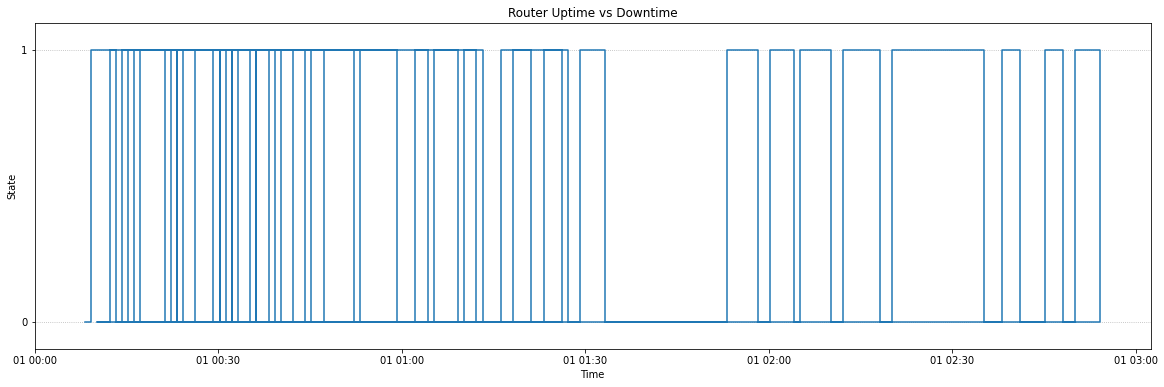

In [37]:
# Plot 2: The "step" plot (what you want)
plt.figure(figsize=(20, 6))
# Use plt.step(). 'where="post"' means the y-value is held from x[i] to x[i+1]
plt.step(df.index, df.state, where='post')
plt.title("Router Uptime vs Downtime")
plt.xlabel("Time")
plt.ylabel("State")
plt.yticks([0, 1]) # Ensure y-axis only shows 0 and 1
plt.ylim(-0.1, 1.1) # Add a little padding to y-axis so 0 and 1 aren't on the edge
plt.grid(True, axis='y', linestyle=':') # Optional grid for clarity

<h2 align=center> Time Spent in Each State (Experimental) </h2>

In [38]:
# Make a copy to work on, to avoid modifying the original df if it's a slice
df_calc = df.copy()

# Calculate the difference in time between consecutive rows.
# This gives the duration for which the *previous* row's state was active.
df_calc['time_delta'] = df_calc.index.to_series().diff()

# Shift the 'state' column down by one.
# This aligns the state with the duration it was active for.
# So, `time_delta` at row `i` corresponds to the duration for `state` at row `i-1`.
df_calc['state_during_delta'] = df_calc['state'].shift(1)

# The first row will have NaT for 'time_delta' and NaN for 'state_during_delta'
# because there's no previous row to calculate from.
# These NaN values will be automatically ignored by the groupby().sum().

print("\nDataFrame with calculations:")
print(df_calc)
print("-" * 30)

# Group by the 'state_during_delta' and sum the 'time_delta'
time_spent_in_each_state = df_calc.groupby('state_during_delta')['time_delta'].sum()

# The result will have states 0.0 and 1.0 as index if 'state' was int.
# We can rename the index for clarity if needed, or convert to int.
time_spent_in_each_state.index = time_spent_in_each_state.index.astype(int)
time_spent_in_each_state.index.name = 'State'

print("\nTime spent in each state:")
print(time_spent_in_each_state)


DataFrame with calculations:
                     state      time_delta  state_during_delta
0                                                             
1981-01-01 00:08:13    0.0             NaT                 NaN
1981-01-01 00:09:13    1.0 0 days 00:01:00                 0.0
1981-01-01 00:13:13    0.0 0 days 00:04:00                 1.0
1981-01-01 00:17:13    1.0 0 days 00:04:00                 0.0
1981-01-01 00:23:13    0.0 0 days 00:06:00                 1.0
...                    ...             ...                 ...
1981-01-01 00:15:12    1.0 0 days 00:01:00                 0.0
1981-01-01 00:21:12    0.0 0 days 00:06:00                 1.0
1981-01-01 00:22:12    1.0 0 days 00:01:00                 0.0
1981-01-01 00:30:12    0.0 0 days 00:08:00                 1.0
1981-01-01 00:31:12    1.0 0 days 00:01:00                 0.0

[68 rows x 3 columns]
------------------------------

Time spent in each state:
State
0   -1 days +21:33:03
1     0 days 02:49:56
Name: time_delta, dt